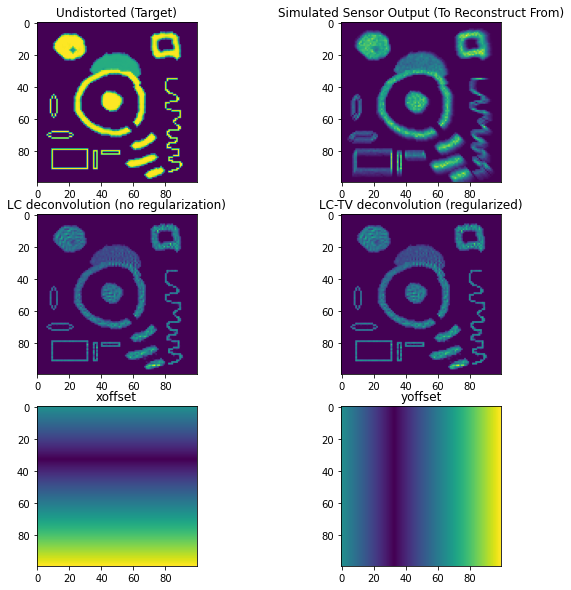

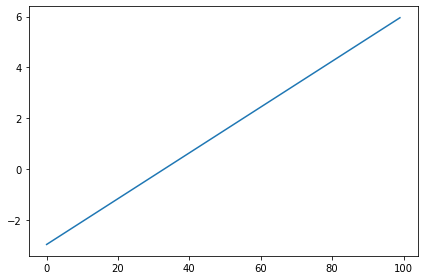

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import examplesetup
import lib.deconvolution as deconvolution
import lib.utils as utils
import lib.xtrace as xtrace

img = image.imread("example_files/example_image.png").sum(axis=2)
img = img - img.min()

config = {
    "detector": {
        "pixel_dims": np.array([1.0, 1.0, 3.0]),
        "mu":  0.3
    },
    "dimensions": np.array(img.shape),
    "ray_origin": np.array([img.shape[0]/3, img.shape[1]/3, img.shape[1]/3]),
}

ray_grid = utils.ray_grid(config["dimensions"])
G = xtrace.depth_spill_psf(config, *ray_grid)

#Apply the point spread function to our image
distorted_img = (G.get()@img.flatten()).reshape(img.shape)

perc, lam = (0.7, 10)
distorted_img = distorted_img * (perc + np.random.poisson(lam, distorted_img.shape)/lam*(1 - perc))

recovered_img = deconvolution.richard_lucy(distorted_img, G, 100)
recovered_img_tv = deconvolution.regularized_richard_lucy(distorted_img, G, 0.002, 100)
fig, axs = plt.subplots(3, 2, figsize=(10,10))
axs[0, 0].imshow(img)
axs[0, 0].set_title("Undistorted (Target)")
axs[0, 1].imshow(distorted_img)
axs[0, 1].set_title("Simulated Sensor Output (To Reconstruct From)")
axs[1, 0].imshow(recovered_img)
axs[1, 0].set_title("LC deconvolution (no regularization)")
axs[1, 1].imshow(recovered_img_tv)
axs[1, 1].set_title(f'LC-TV deconvolution (regularized)')

xoffsets, yoffsets = xtrace.depth_offsets(config, *ray_grid)
axs[2, 0].imshow(np.abs(xoffsets))
axs[2, 0].set_title("xoffset")
axs[2, 1].imshow(np.abs(yoffsets))
axs[2, 1].set_title("yoffset")

plt.figure()
plt.plot(yoffsets[0])
plt.tight_layout()
plt.show()
